# zfit — A simple introduction

In this quick tutorial, we'll show the basic ideas on what you can do with `zfit`, without going into much detail or performing advanced tasks.

First, we will perform the basic imports that we will use along most of the tutorials, and we'll check the `tensorflow` version.



In [1]:
import numpy as np
import tensorflow as tf

import zfit
# Wrapper for some tensorflow functionality
from zfit import ztf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 1.12.0


## Create observables

The observable space in which PDFs are defined is created with the `Space` class,

In [2]:
obs = zfit.Space('x', limits=(-10, 10))

## Create data

We need to create some data using `numpy`.

In [3]:
mu_true = 0.
sigma_true = 1.
data_np = np.random.normal(mu_true, sigma_true, size=10000)
data = zfit.data.Data.from_numpy(obs=obs, array=data_np)

## Create a PDF to fit

Now let's create a Gaussian PDF so we can fit the dataset. To do this, first we create the fit parameters, which follow a convention similar to `RooFit`:

```
zfit.Parameter(name, initial_value, lower_limit (optional), upper_limit (optional), other options)
```

In [4]:
mu = zfit.Parameter("mu", 2.4, -1., 5.)
sigma = zfit.Parameter("sigma", 1.3, 0, 5.)

Now we instantiate a Gaussian from the zfit PDF library (more on how to create your own PDFs later)

In [5]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

This object object contains all the functions you would expect from a PDF, such as calculating a probability, calculating its integral, etc.

**NB**: Currently, one important caveat is that all `zfit` objects are based on `tensorflow`, and therefore they are graphs that are not executed immediately, but need to be run on a session:

```python
zfit.run(TensorFlow_object)
```

In [6]:
# Now, get some probability values
# The probs object is not executed yet
consts = [-1, 0, 1]
probs = gauss.pdf(ztf.constant(consts), norm_range=(-np.infty, np.infty))
# And now execute the tensorflow graph
result = zfit.run(probs)
print("x values: {}\nresult:   {}".format(consts, result))

x values: [-1, 0, 1]
result:   [0.01003756 0.05582995 0.17184121]


## Fitting

To fit, we need to take three steps (**to be fixed in the future**): create the negative $\log\mathcal{L}$, instantiate a minimizer and then minimize the likelihood. 

*Note*: IN this case, we don't need to execut the graph (we need to make this consistent)

In [7]:
# Create the negative log likelihood
from zfit.core.loss import UnbinnedNLL

nll = UnbinnedNLL(model=[gauss], data=[data], fit_range=[obs])

# Load and instantiate a tensorflow minimizer
from zfit.minimizers.minimizer_minuit import MinuitMinimizer
minimizer = MinuitMinimizer()

# Create the minimization graph to minimize mu and sigma and run it (minimize does it directly)
minimum = minimizer.minimize(loss=nll, params=[mu, sigma])

# Get the fitted values, again by run the variable graphs
params = minimum.params

print("mu={}".format(params[mu]['value']))
print("sigma={}".format(params[sigma]['value']))

/home/jonas/Documents/physics/software/zfit_project/zfit_repo/zfit/minimizers/minimizer_minuit.py:69: InitialParamWarning: errordef is not given. Default to 1.
  **error_limit_kwargs)


FCN = 14090.896762543465 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 7.109036213119718e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu:0,-0.00320947,0.0140036,,,-1,5,No
1,sigma:0,0.990186,0.00990165,,,0,5,No


mu=-0.003209468747102262
sigma=0.9901864543172003


And we can plot the result to see how it went.

*TODO*: Make plotting easy (but not really integrated)

In [8]:
%matplotlib inline  

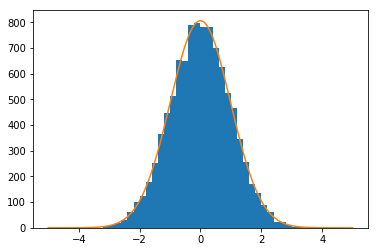

In [10]:
import matplotlib.pyplot as plt
n_bins = 50
range_ = (-5,5)
_ = plt.hist(data_np, bins=n_bins, range=range_)
x = np.linspace(*range_, num=1000)
pdf = zfit.run(gauss.pdf(x, norm_range=(-10, 10)))
_ = plt.plot(x, data_np.shape[0]/n_bins*10.*pdf)

Here, we can see the power of the context managers used to change the normalisation range.

In [11]:
with gauss.set_norm_range((-1e6, 1e6)):  # play around with different norm ranges
# with gauss.set_norm_range((-100, 100)):
    print(zfit.run(gauss.integrate((-0.6, 0.6))))
    print(zfit.run(gauss.integrate((-3, 3))))
    print(zfit.run(gauss.integrate((-100, 100))))

[0.45544761]
[0.99755217]
[1.]


*(remember the orders of magnitude: sigma of our Gaussian is 1, so 100 is far far away)*